<a href="https://colab.research.google.com/github/yongjulee0213/ale_python_interface/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#coding transfer learning from the inception model

In [19]:
#setup gpu
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 7s (57.1 MB/s)
(Reading database ... 157604 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 157582 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+c

In [20]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-09-27 01:53:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 142.250.107.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   149MB/s    in 0.6s    

2022-09-27 01:53:28 (149 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [23]:
#load weight from inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file='/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

#initialize the base model + set the input shape + remove the dense layers
pre_trained_model=InceptionV3(input_shape=(150,150,3),
                              include_top=False,
                              weights=None)

#load the pre_trained weights I downloaded
pre_trained_model.load_weights(local_weights_file)

#freeze the weights of the layers
for layer in pre_trained_model.layers:
  layer.trainable=False

In [24]:
#model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [25]:
#choose 'mixed7'as the last layer of my base model
last_layer=pre_trained_model.get_layer('mixed7')
print('last layer output shape: ',last_layer.output_shape)
last_output=last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [28]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [34]:
#set the trainig parameters
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
#prepare dataset

In [31]:
#download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2022-09-27 02:01:59--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   166MB/s    in 0.4s    

2022-09-27 02:02:00 (166 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [32]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [36]:
#train the model
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Epoch 1/20
100/100 [==============================] - 147s 1s/step - loss: 0.3474 - accuracy: 0.8635 - val_loss: 0.1184 - val_accuracy: 0.9520
Epoch 2/20
100/100 [==============================] - 143s 1s/step - loss: 0.2127 - accuracy: 0.9185 - val_loss: 0.1933 - val_accuracy: 0.9350
Epoch 3/20
100/100 [==============================] - 144s 1s/step - loss: 0.2241 - accuracy: 0.9180 - val_loss: 0.1132 - val_accuracy: 0.9650
Epoch 4/20
100/100 [==============================] - 142s 1s/step - loss: 0.1987 - accuracy: 0.9340 - val_loss: 0.1371 - val_accuracy: 0.9550
Epoch 5/20
100/100 [==============================] - 145s 1s/step - loss: 0.1862 - accuracy: 0.9370 - val_loss: 0.1027 - val_accuracy: 0.9650
Epoch 6/20
100/100 [==============================] - 144s 1s/step - loss: 0.1824 - accuracy: 0.9360 - val_loss: 0.1358 - val_accuracy: 0.9570
Epoch 7/20
100/100 [==============================] - 146s 1s/step - loss: 0.1297 - accuracy: 0.9545 - val_loss: 0.1621 - val_accuracy: 0.9560

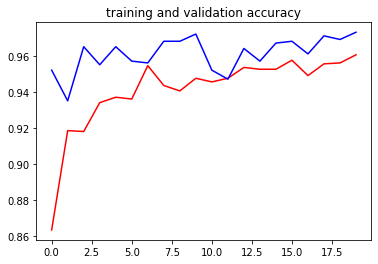

<Figure size 432x288 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc,'r',label='training accuracy')
plt.plot(epochs, val_acc,'b',label='validation accuarcy')
plt.title('training and validation accuracy')
plt.figure()

plt.show()